# 使用大模型解析输入并生成图片

## 使用gpt-4o解析输入

In [2]:
import requests
import json
import matplotlib.pyplot as plt

In [3]:
def get_openai_replay(mes="Hello!"):
    APIKEY = "sk-eMec4caa2bea3c24723e7ff511337862b95d5e39eeetapn8"
    url = "https://api.gptsapi.net/v1/chat/completions"
    headers = {"Content-Type": "application/json",
            "Authorization": f"Bearer {APIKEY}"}
    _input = {"model": "gpt-4o",
            "messages":
            [
                {
                    "role": "user",
                    "content": mes
                }
            ]
            }
    res=requests.post(url,headers=headers,data=json.dumps(_input))
    resjson=res.json()
    return resjson["choices"][0]['message']['content']


# get_openai_replay("仅仅输出prompt，用英语输出dall-e3画图的prompt。我想画一个icon的图片，纯色背景，比例1:1，一个人拿着手机")


In [16]:
def get_image_replay(prompt="Create an icon with a solid color background and a 1:1 aspect ratio. The main element should be a large gold coin in the center. Surrounding the large coin, include smaller gold coins, a calendar, and a clock."):
    APIKEY = "sk-eMec4caa2bea3c24723e7ff511337862b95d5e39eeetapn8"
    url = "https://api.gptsapi.net/v1/images/generations"
    headers = {"Content-Type": "application/json",
               "Authorization": f"Bearer {APIKEY}"}
    _input = {"model": "dall-e-3",
              "prompt": prompt
              }
    res = requests.post(url, headers=headers, data=json.dumps(_input))
    resjson = res.json()

    image=requests.get(resjson["data"][0]['url'])
    f=open("temp.jpg","wb")
    f.write(image.content)
    return image.content


image=get_image_replay("A minimalist icon image with a person holding a smartphone, set against a solid color background. The design should be simple and clean, with a focus on the person and the smartphone. The person should be in a neutral, non-distracting pose, and the smartphone should be clearly visible. The background should be a single, solid color without any gradients or patterns. The overall composition should be balanced and visually appealing. Proportion: 1:1.")


## 将图片抠图出来

In [1]:
removebgapikey="xLSRRKecS1xdo8btBturrw75"
import requests
from PIL import Image
from io import BytesIO



# 要处理的图片文件路径
input_path = 'temp.jpg'
# 输出结果保存路径
output_path = 'image1.png'

def remove_background(input_path, output_path):
    with open(input_path, 'rb') as image_file:
        response = requests.post(
            'https://api.remove.bg/v1.0/removebg',
            files={'image_file': image_file},
            data={'size': 'auto'},
            headers={'X-Api-Key': removebgapikey}
        )
    
    if response.status_code == requests.codes.ok:
        image = Image.open(BytesIO(response.content))
        image.save(output_path)
        print(f"Background removed and saved to {output_path}")
    else:
        print(f"Error: {response.status_code}")
        print(response.text)

# 移除图片背景
remove_background(input_path, output_path)

Background removed and saved to image1.png


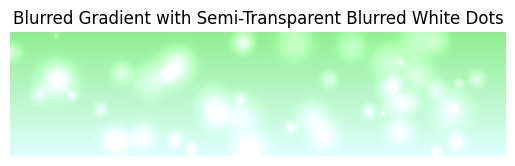

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Step 1: Create a gradient image from light green to light yellow with alpha channel
height, width = 400, 1600  # You can adjust the size of the image
gradient = np.zeros((height, width, 4), dtype=np.uint8)
color1=(144, 238, 144,255)
color2=(255, 255, 224,255)

for i in range(height):
    ratio = i / height
    color = (
        int(color1[0] * (1 - ratio) + color2[0] * ratio),
        int(color1[1] * (1 - ratio) + color2[1] * ratio),
        int(color1[2] * (1 - ratio) + color2[2] * ratio),255
    )
    gradient[i, :] = color


# Step 2: Add random white dots with varying sizes and 20% opacity, with blurred edges
num_dots = 50  # You can adjust the number of white dots
for _ in range(num_dots):
    x = np.random.randint(0, width)
    y = np.random.randint(0, height)
    radius = np.random.randint(5, 51)  # Radius from 5 to 50 (which gives a diameter from 10 to 100)
    
    # Create a temporary overlay for the dot
    dot = np.zeros((height, width, 4), dtype=np.uint8)
    cv2.circle(dot, (x, y), radius, (255, 255, 255, 51), -1)  # 20% opacity
    
    # Blur the dot to soften the edges
    blurred_dot = cv2.GaussianBlur(dot, (0, 0), sigmaX=radius/2, sigmaY=radius/2)
    
    # Add the blurred dot to the gradient image with appropriate blending
    gradient = cv2.addWeighted(gradient, 1.0, blurred_dot, 0.2, 0)

# Step 3: Apply Gaussian blur with a kernel size of 5 pixels to the entire image
bgr = cv2.cvtColor(gradient, cv2.COLOR_BGRA2BGR)
blurred_bgr = cv2.GaussianBlur(bgr, (5, 5), 0)
blurred_alpha = cv2.GaussianBlur(gradient[:, :, 3], (5, 5), 0)
blurred_image = cv2.merge((blurred_bgr, blurred_alpha))

# Display the resulting image
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGRA2RGBA))

plt.imsave("background.png",blurred_image)
plt.title('Blurred Gradient with Semi-Transparent Blurred White Dots')
plt.axis('off')
plt.show()


In [19]:
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# 打开背景图
background = Image.open('background.png')

# 打开带透明度的图片1
image1 = Image.open('image1.png').convert("RGBA")

# 将图片1高度按比例缩放到和背景一致
bg_width, bg_height = background.size
img1_width, img1_height = image1.size
new_img1_height = bg_height
new_img1_width = int((new_img1_height / img1_height) * img1_width)
image1_resized = image1.resize((new_img1_width, new_img1_height), Image.Resampling.LANCZOS)

# 将缩放后的图片1放到背景最右侧
background.paste(image1_resized, (bg_width - new_img1_width, 0), image1_resized)

# 在背景左侧写文字，由上到下3行
draw = ImageDraw.Draw(background)

# 设置字体路径
font_path1 = "/Library/Fonts/Arial Unicode.ttf"  # 替换为你的字体路径
font_path2 = "/Library/Fonts/Arial Unicode.ttf"  # 替换为你的字体路径

font1 = ImageFont.truetype(font_path1, 32)
font2 = ImageFont.truetype(font_path2, 20)

# 第一行文字
draw.text((100, 100), "财富增值好帮手，理财投资轻松享！", font=font1, fill=(239,167,4))

# 第二行文字
draw.text((100, 150), "Content", font=font2, fill="black")

# 将PIL图像转换为OpenCV图像
background_cv = cv2.cvtColor(np.array(background), cv2.COLOR_RGBA2BGRA)

# 保存结果图像
cv2.imwrite('result.png', background_cv)


True

In [4]:
get_openai_replay("生成一个营销理财产品的广告语，要求20个字以内")

'"财富增值好帮手，理财投资轻松享！"'

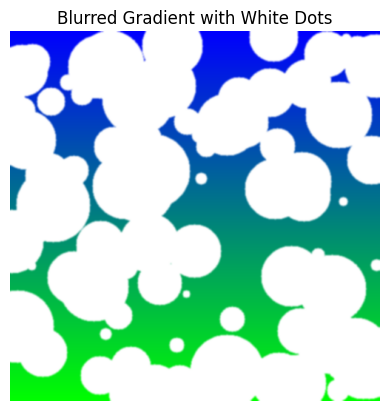

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_gradient_image(color1, color2, width, height):
    """Create a gradient image from color1 to color2."""
    gradient = np.zeros((height, width, 3), dtype=np.uint8)
    for i in range(height):
        ratio = i / height
        color = (
            int(color1[0] * (1 - ratio) + color2[0] * ratio),
            int(color1[1] * (1 - ratio) + color2[1] * ratio),
            int(color1[2] * (1 - ratio) + color2[2] * ratio)
        )
        gradient[i, :] = color
    return gradient

# Step 1: Create a gradient image
color1 = (255, 0, 0)  # Red
color2 = (0, 255, 0)  # Green
width, height = 500, 500
gradient = create_gradient_image(color1, color2, width, height)

# Step 2: Add random white dots
num_dots = 100  # Number of white dots
for _ in range(num_dots):
    x = np.random.randint(0, width)
    y = np.random.randint(0, height)
    radius = np.random.randint(5, 51)  # Radius from 5 to 50 pixels
    cv2.circle(gradient, (x, y), radius, (255, 255, 255), -1)

# Step 3: Apply Gaussian blur with a kernel size of 5 pixels
blurred_image = cv2.GaussianBlur(gradient, (5, 5), 0)

# Display the resulting image
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Gradient with White Dots')
plt.axis('off')
plt.show()
